In [4]:
import pandas as pd
import numpy as np
from typing import Optional, List, Callable, Any, Union, Dict
from itertools import product
from statistics import mean
from pathlib import Path
import gzip
import os

### Read datasets
Use the gzip function is files ar gzipped

In [5]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [6]:
# features_train = read_ds(Path(os.path.abspath('')) / "data/TRAIN.CSV") # Replace with correct path 
# features_test = read_ds("TEST")
features_train = read_ds_gzip(Path(os.path.abspath('')) / "data/TRAIN.CSV.gz", "TRAIN")
features_train.shape #, features_test.shape

(3052, 10539)

### Dependent Variable
Our dependent variable is a categorical string; we can convert it to categories codes (number) with pd.Categorical

pd.Categorical doesn't directly modify the battleneturl to a number, instead it adds a cat.codes attribute to it. We can create a little function to convert the dependent variable from string to its category ID:

In [8]:
def to_categories(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert col of df to a categorical column"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df[[col]] = df[[col]].apply(lambda x: x.cat.codes)

#### Removing outliers
YOUR IDEAS / APPROACHES HERE.



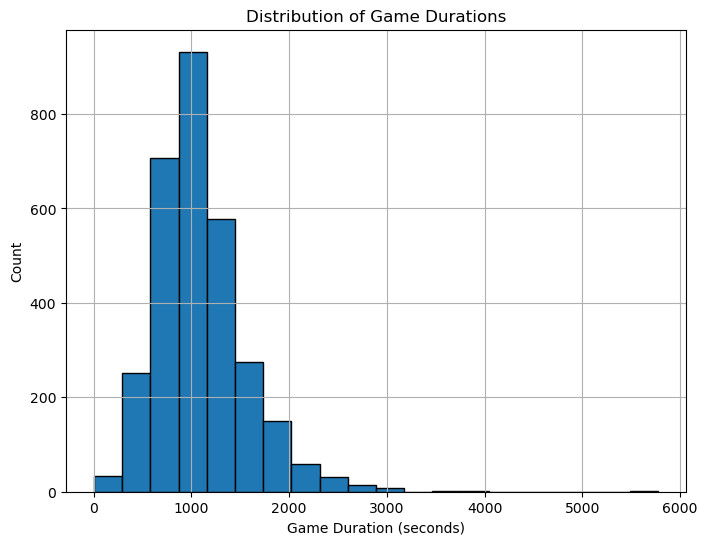

In [11]:
import matplotlib.pyplot as plt
to_categories(features_train)

durations = []
    
# Iterate over each row in the dataframe
for _, row in features_train.iterrows():
    # Convert the row to a list (strings, possibly some NaN if missing)
    row_list = row.tolist()
    
    # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
    time_tokens = [
        col for col in row_list
        if isinstance(col, str) and col.startswith('t')
    ]
    
    if time_tokens:
        # Get the last time token in the row
        last_time_token = time_tokens[-1]
        # Convert from e.g. "t135" -> integer 135
        duration = int(last_time_token[1:])
        durations.append(duration)
    else:
        # If no time tokens, we can append None or skip.
        durations.append(None)

# Store the durations in the dataframe as a new column for convenience
features_train['duration'] = durations

# Drop rows without a valid duration
features_train.dropna(subset=['duration'], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train['duration'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Game Durations')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

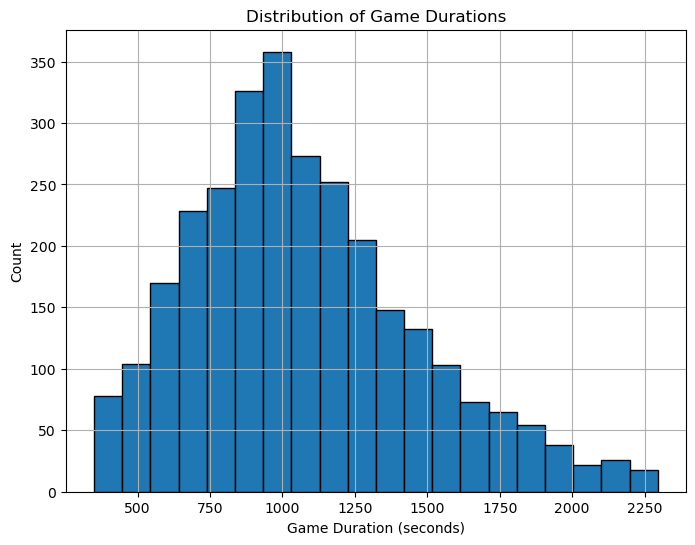

In [18]:

# Keep the central 96% (remove bottom and top 2%)
q125 = features_train['duration'].quantile(0.02)
q875 = features_train['duration'].quantile(0.98)
features_train_filtered = features_train[(features_train['duration'] >= q125) & (features_train['duration'] <= q875)]
    

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train_filtered['duration'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Game Durations')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### Getting features...

Building a mini framework to read our Dataframe and convert it to features.

Now we will create features out of the dataset.

FeaturesGetter iterates over an ActionsDataLoader (yield every actions between two 't[xx]') and apply a set of Feature contained in a FeaturePool. At the end, it gets metrics over the values registered by each features in the feature pool.

In [35]:
class CancelBatchException(Exception):
    """Used to cancel processing of a batch of data (when the keystroke sequence is fully read)"""

In [36]:
class Feature:
    def __init__(
        self, name: str, 
        lambda_: Callable[[List[str]], Union[int, float]]=None, 
        val_count: int=None, 
        max_iter: int=None, 
        predicate: Callable[[List[str]], bool]=None, 
        metric: Callable[[List[str]], Union[int, float]]=mean, 
        div: bool=True
    ):
        """If neither lambda_, val_count nor predicate are defined, the _lambda will just be the length of the given action range.

        Args:
            name (str): feature name
            lambda_ (Callable[[List[str]], Union[int, float]], optional): 
                lambda that'll be applied to compute metric value over action ranges. Defaults to None.
            val_count (int, optional): set feature's lambda to be the count of this value (if lambda_ is None). Defaults to None.
            max_iter (int, optional): when exceeding this iteration, the feature will no longer be computed. Defaults to None.
            predicate (Callable[[List[str]], bool], optional): define a predicate to compute lambda across one 
                action range (if lambda_ and val_count is None). Defaults to None.
            metric (Callable[[List[str]], Union[int, float]], optional): the metric used to aggregate feature's 
                values across all ranges. Defaults to mean.
            div (bool, optional): whether to divide the aggregated metric value. Defaults to True.
        """
        self.name, self.metric, self.max_iter, self.div = name, metric, max_iter, div
        self.reset()
        self._lambda: Callable[[List[str]], Union[int, float]]
        if   lambda_   is not None: 
            self._lambda = lambda_
        elif val_count is not None: 
            self._lambda = lambda x: x.count(val_count)
        elif predicate is not None: 
            self._lambda = lambda x: sum(1 for o in x if predicate(o))
        else: 
            self._lambda = lambda x: len(x)
    
    def reset(self):
        """Resets the value of the feature
        """
        self.vals: List[Union[int, float]] = []
        self.val, self.i = 0, 0
        
    def __call__(self, rng: List[str], *args):
        """Compute feature's value according to _lambda, for given action range. Extra *args are given to _lambda

        Args:
            rng (List[str]): range of action (given by ActionDataLoader)
        """
        if self.max_iter is None or self.i < self.max_iter:
            self.val = self._lambda(rng, *args)
            self.vals.append(self.val)
            self.i += 1
            
    @property
    def value(self) -> int | float:
        """Returns:
            int | float: the aggregated feature's value across all action ranges read until now
        """
        return self.metric(self.vals)

In [54]:
class ActionsDataLoader:
    """Iterates over two 'tXX', yielding actions between each time steps
    """
    def __init__(self, actions: pd.DataFrame, do_range: bool = True, max_t: Optional[int]=None):
        """Args:
            actions (List[Feature]): The raw dataframe
            do_range (bool): whether the data loader should iterate and yield each range 
                between two 'tXX', or just yield the whole sequence once then return. Defaults to True.
            max_t (Optional[int], optional): the t max to stop yielding. Defaults to None.
        """
        self.t_indx = [0] + [j for j, val in enumerate(actions) if isinstance(val, str) and val[0] == "t"]
        self.do_range = do_range
        if max_t and max_t < len(self.t_indx):
            self.t_indx = self.t_indx[:max_t]
            self.values = actions.values[: self.t_indx[max_t - 1]]
        else: 
            self.values = actions.values
        self.n_t = len(self.t_indx)
    
    def __len__(self): return 1 if self.do_range else (self.n_t or 1)
    
    def __iter__(self):
        if self.n_t == 0 or not self.do_range:
            self.start_indx = 0
            self.end_indx = self._get_first_nan_indx()
            yield self.values[self.start_indx:self.end_indx].tolist()
            return 
        for self.i in range(self.n_t):
            try:
                self._get_actions_range()
                yield self.values[self.start_indx:self.end_indx].tolist()
            except CancelBatchException: 
                return

    def _get_actions_range(self):
        """Computes the action range until a 'tXX' is met. If there are no more 'tXX', 
            it means we reached the end of the game, and the sequences finish with NaN 
            (or for the longest game, the full row is read).

        Raises:
            CancelBatchException: indicates that there is no more action to be read (next action is NaN).
        """
        self.start_indx = self.t_indx[self.i] + (1 if self.i >0 else 0)
        if  self.start_indx >= len(self.values) or pd.isna(self.values[self.start_indx]): 
            raise CancelBatchException
        self.end_indx = self.t_indx[self.i + 1] if (self.i + 1) < self.n_t else self._get_first_nan_indx()
    
    def _get_first_nan_indx(self) -> int:
        """Returns:
            int: the first index in values that is not NaN
        """
        nans = np.argwhere(pd.isna(self.values[self.start_indx:]))
        return len(self.values) if len(nans) == 0 else nans[0][0]
    
    def get_max_t(self):
        """Gets the last 'tXX' defined. If this data loader was defined with max_t not None, it returns this max_t
        """
        if self.n_t - 1 == 0:
            return 0
        return int(self.values[self.t_indx[self.n_t - 1]][1:]) if self.n_t > 0 else 0

In [45]:
class FeaturesGetter:
    def __init__(self, features: List[Feature], n_rows: int=3052, log: bool=False, **kwargs_dataloader):
        """Args:
            features (List[Feature]): the list of features to compute
            n_rows (int, optional): the number of row (used only in log). Defaults to 3052.
            log (bool, optional): whether to output log information when processing the df. Defaults to False.

            Accepts extra kwargs_dataloader that'll be passed to the dataloader
        """
        self.feature_pool, self.n_rows, self.log, self.kwargs_dataloader = features, n_rows, log, kwargs_dataloader
        self.game_l: int # game length
        self.reset()
        
    def reset(self):
        """Resets the value of each feature in the feature pool"""
        for feature in self.feature_pool: 
            feature.reset()
        self.game_l = 0
    
    def _log(self):
        """Print to stdout the current % of the df that have been processed"""
        global cnt
        cnt += 1
        print(f"{cnt * 100 / self.n_rows:.2f} %", end="\r")
    
    def _one_update(self):
        """Compute each feature's value for one batch (one action range yielded by the ActionDataLoader)"""
        for feature in self.feature_pool: 
            feature(self.actions_rng)
        
    def __call__(self, actions: pd.DataFrame) -> pd.Series:
        """Computes all features' values for each of the given actions, iterating over ADL with parameters defined in __init__
        
        Returns:
            pd.Series: the features' values as a Series. 
                Adds an extra feature which is the game length is max_t is not in __init__ kwargs
        """
        self.reset()
        if self.log:
            self._log()
        adl = ActionsDataLoader(actions, **self.kwargs_dataloader)
        for self.actions_rng in adl:
            self._one_update()
        activs = [f.value / len(adl) if f.div else f.value for f in self.feature_pool]
        self.game_l = (max_t := self.kwargs_dataloader.get("max_t", None)) or adl.get_max_t()
        return pd.Series( activs + ([self.game_l] if max_t is None else []) )

Defining lambdas to convert dataset to features
We create basic features, corresponding to the mean of each action played per timestamp plus the mean of all actions together

In [46]:
FEATURES_NAMES = ["s_mean", "base_mean", "mineral_mean", "hotkeys_mean", "actions_mean"]
ACTIONS = [ "s", "Base", "SingleMineral", "hotkey" ]

def get_base_features() -> List[Feature]:
    """Defines base features (mean of count of each action / hotkeys)
    """
    features = []
    for i, action in enumerate(ACTIONS[:-1]):
        features.append(Feature(FEATURES_NAMES[i], val_count=action))
    features.append(Feature(FEATURES_NAMES[-2], predicate=lambda x: x.startswith(ACTIONS[-1]))) # hotkeys
    features.append(Feature(FEATURES_NAMES[-1])) # all actions combined (no lambda_ means lambda_ is just the length)
    for i, j in product(range(10), range(3)):
        pass
    #TODO
        # OTHER FEATURES HERE
    # OTHER FEATURES HERE
    # Guess what would be useful ?
    # set div, metric and lambda_ accordingly
    return features

Now it's ready to be put into a function that'll get all the features from the initial dataframe and return a new dataframe containing only those features. FeaturesGetter gets one extra feature from that we created, which is max_time, corresponding to the "xx" of the last "txx" seen.

In [47]:
features_getter = None
def create_features(
    df: pd.DataFrame, 
    min_: int, 
    max_: int, 
    drop: bool=False, 
    features: List[Feature]=get_base_features(), 
    **kwargs
) -> pd.DataFrame:
    """Compute features on given dataframe

    Args:
        df (pd.DataFrame)
        min_ (int): index of the first action to pass to the feature
        max_ (int): index of the last action to pass to the feature
        drop (bool, optional): whether to drop original columns of the dataframe. Defaults to False.
        features (List[Feature], optional). Defaults to get_base_features().

    Returns:
        pd.DataFrame: a dataframe containing features' values for each row
    """
    global features_getter
    features_getter = FeaturesGetter(features, **kwargs)
    final_df = df.loc[:,min_:max_].apply(features_getter, axis=1, result_type='expand')
    final_df.columns = [f.name for f in features_getter.feature_pool] + (["max_time"] if not kwargs.get("max_t") else [])
    if drop:
        df = df.drop(columns=[i for i in range(min_, max_ + 1)])
    final_df = pd.concat([df, final_df], axis=1)
    features_getter.reset()
    return final_df

### Handling string
The race_played column can only take three values; instead of converting it to categorical as we did with our dependent variable, we will instead convert it to dummy variables: we one-hot encode each race. It will not add many columns to our dataframe (only three) but will allow the decision trees to split much faster on the race (on only one binary split).

In [41]:
def get_dummies(df: pd.DataFrame):
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=["played_race"])
    return df

Function preprocess creates a pipeline of all the function we just implemented: it create the features, converts the race to dummy variables and the dependent variable to category codes.

In [48]:
def preprocess(df: pd.DataFrame, min_: int, max_: int, is_train: bool=True, convert_race: bool=True, **kwargs):
    """Calls FeatureGetter on the dataframe, applying preprocessing steps before
    Args:
        df (pd.DataFrame)
        min_ (int)
        max_ (int)
        is_train (bool, optional): whether the current dataframe contains training data 
            (to preprocess dependent variable or not). Defaults to True.
        convert_race (bool, optional): whether to convert race attribute to dummies. Defaults to True.

    Returns:
        _type_: _description_
    """
    df = create_features(df, min_, max_, **kwargs)
    if convert_race: 
        df = get_dummies(df)
    df.columns = df.columns.astype(str)
    if is_train:
        to_categories(df)
    return df

In [56]:
%%time
cnt=0
processed_df = preprocess(features_train, 0, features_train.shape[1]-3, drop=True, n_rows=3052, log=True) 
processed_df.head()

CPU times: user 44.3 s, sys: 181 ms, total: 44.5 s
Wall time: 44.3 s


,battleneturl,s_mean,base_mean,mineral_mean,hotkeys_mean,actions_mean,hotkey00_mean,hotkey01_mean,hotkey02_mean,hotkey10_mean,...,hotkey80_mean,hotkey81_mean,hotkey82_mean,hotkey90_mean,hotkey91_mean,hotkey92_mean,max_time,played_race_Protoss,played_race_Terran,played_race_Zerg
0,53,2.036254,0.199396,0.015106,4.492447,6.743202,0.015106,0.0,0.123867,0.190332,...,0.000000,0.0,0.000000,0.012085,0.0,0.000000,1655.0,True,False,False
1,29,1.620482,0.036145,0.000000,4.596386,6.253012,0.006024,0.0,0.250000,0.195783,...,0.003012,0.0,0.048193,0.003012,0.0,0.054217,1655.0,True,False,False
2,53,2.128713,0.232673,0.014851,4.297030,6.673267,0.014851,0.0,0.089109,0.084158,...,0.000000,0.0,0.000000,0.009901,0.0,0.009901,1010.0,True,False,False
3,29,1.965347,0.103960,0.000000,4.787129,6.856436,0.009901,0.0,0.188119,0.158416,...,0.000000,0.0,0.000000,0.004950,0.0,0.069307,1005.0,True,False,False
4,53,1.925926,0.018519,0.000000,3.787037,5.731481,0.009259,0.0,0.000000,0.092593,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,540.0,True,False,False
